# Running Tests

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

from game.GridGeneration import DisjointBlobs
from htn.my_htn import DictBasedHTN

plt.style.use('default')
labels = ["normal", "many small", "big"]

## Maze Complexity Analysis
The following code investigate how well the HTN performs as maze complexity increases for the current obstacles that means more blobs and greater blob masses.

In [10]:
max_counts = range(1, 11)
max_sizes = range(2, 21, 2)
num_episodes = 200
base_seed = 42

avg_lengths = np.zeros((len(max_sizes), len(max_counts)))

for i, max_size in enumerate(max_sizes):
    print(i)
    for j, max_count in enumerate(max_counts):
        lengths: list[int] = []
        for k in range(num_episodes):
            seed = base_seed + k
            obstacle_gen = DisjointBlobs(
                max_count=max_count,
                max_size=max_size,
            )
            game = DictBasedHTN(
                h=18,
                w=18,
                n=9,
                m=9,
                num_fake_targets=0,
                obstacle_scheme=obstacle_gen,
            )
            game_len = game.play_game(seed=seed)
            lengths.append(game_len)
        avg_lengths[i, j] = np.mean(lengths)
        #print(f"max_count={max_count}, max_size={max_size} -> avg_len={avg_lengths[i,j]:.2f}")

0
1
2
3
4
5
6
7
8
9


### Plot the data

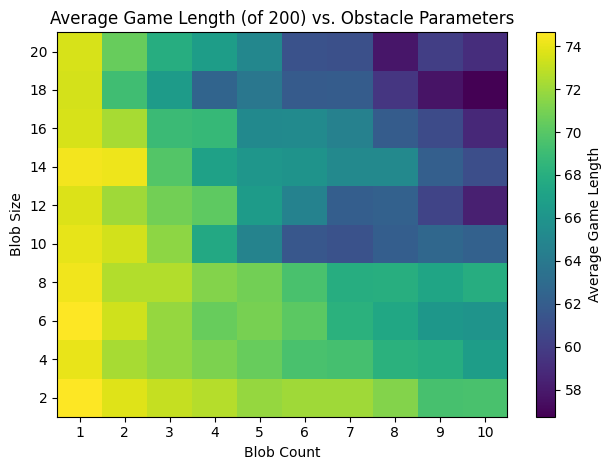

In [11]:
# ---- Visualization as heat map ----
fig, ax = plt.subplots()

# imshow will use the default colormap; no custom colors specified
im = ax.imshow(avg_lengths, origin="lower", aspect="auto")

# Tick labels correspond to your parameter values
ax.set_xticks(np.arange(len(max_counts)))
ax.set_xticklabels(max_counts)
ax.set_yticks(np.arange(len(max_sizes)))
ax.set_yticklabels(max_sizes)

ax.set_xlabel("Blob Count")
ax.set_ylabel("Blob Size")
ax.set_title("Average Game Length (of 200) vs. Obstacle Parameters")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Average Game Length")

plt.tight_layout()
plt.show()

## Maze Vision Ability Analysis
The following code investigate how well the HTN performs as the agent's vision ability increases ie it can see farther in the maze.

In [14]:
small_board_results: tuple[list[float], ...] = ([], [], [])
medium_board_results: tuple[list[float], ...] = ([], [], [])
large_board_results: tuple[list[float], ...] = ([], [], [])

obstacle_schemes = [
    DisjointBlobs(max_count=6, max_size=5),   # normal
    DisjointBlobs(max_count=15, max_size=2),  # many small
    DisjointBlobs(max_count=3, max_size=15),  # big
]

base_seed = 42

def avg_runs(game_factory, seed_start: int, runs: int = 200) -> float:
    """Run multiple games with incremental seeds and return average length."""
    return sum(game_factory(seed_start + k) for k in range(runs)) / runs

for i in range(3, 12, 2):
    print(i)

    for idx, obstacle_gen in enumerate(obstacle_schemes):

        # ---- small board ----
        small_board_results[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=12, w=12, n=i, m=100,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

        # ---- medium board ----
        medium_board_results[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=24, w=24, n=i, m=100,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

        # ---- large board ----
        large_board_results[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=36, w=36, n=i, m=100,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

3
5
7
9
11


### Plotting individually

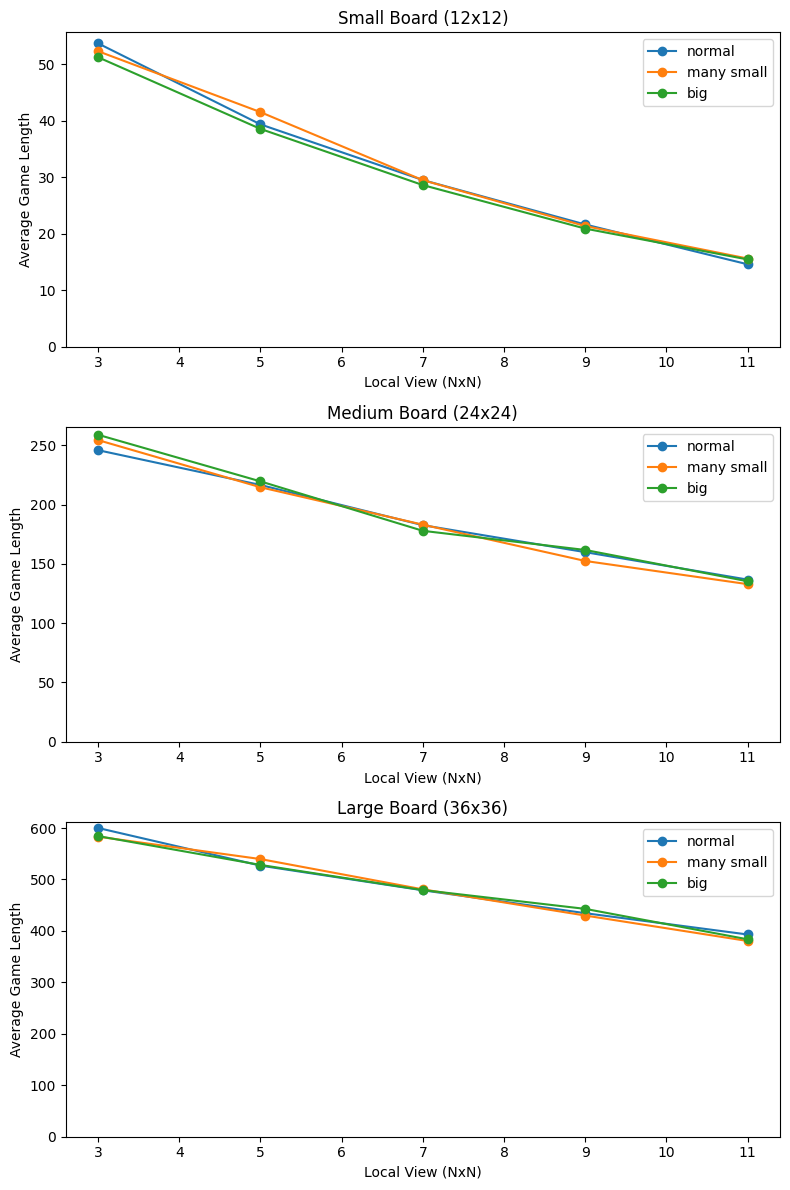

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

viewing_distances = list(range(3, 12, 2))

board_sets = [
    (axes[0], small_board_results, "Small Board (12x12)"),
    (axes[1], medium_board_results, "Medium Board (24x24)"),
    (axes[2], large_board_results, "Large Board (36x36)"),
]

for ax, board_result, title in board_sets:
    for label, series in zip(labels, board_result):
        ax.plot(viewing_distances, series, marker="o", label=label)
    ax.set_title(title)
    ax.set_xlabel("Local View (NxN)")
    ax.set_ylabel("Average Game Length")
    ax.set_ylim(bottom=0)
    ax.legend()

plt.tight_layout()
plt.show()


### Plotting together

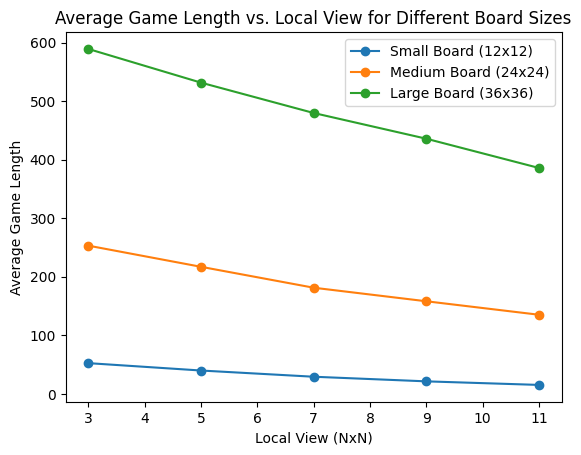

In [17]:
small_avg = [np.mean([small_board_results[0][i], small_board_results[1][i], small_board_results[2][i]]) for i in range(len(viewing_distances))]
medium_avg = [np.mean([medium_board_results[0][i], medium_board_results[1][i], medium_board_results[2][i]]) for i in range(len(viewing_distances))]
large_avg = [np.mean([large_board_results[0][i], large_board_results[1][i], large_board_results[2][i]]) for i in range(len(viewing_distances))]

plt.plot(viewing_distances, small_avg, marker='o', label='Small Board (12x12)')
plt.plot(viewing_distances, medium_avg, marker='o', label='Medium Board (24x24)')
plt.plot(viewing_distances, large_avg, marker='o', label='Large Board (36x36)')
plt.xlabel('Local View (NxN)')
plt.ylabel('Average Game Length')
plt.title('Average Game Length vs. Local View for Different Board Sizes')
plt.legend()
plt.show()

### Modelling the Relationship

In [10]:
for board_name, board_result in [("small", small_board_results), ("medium", medium_board_results), ("large", large_board_results)]:
    slopes = []
    for label, series in zip(labels, board_result):
        slope, intercept, r_value, p_value, std_err = linregress(viewing_distances, series)
        print(f"{board_name} {label}: slope={slope:.2f}, intercept={intercept:.2f}, r^2={r_value**2:.2f}")
        slopes.append(slope)
    avg_slope = 2*np.mean(slopes)
    print(f"{board_name} average slope per radius increase: {avg_slope:.2f}")

small normal: slope=-4.80, intercept=65.38, r^2=0.98
small many small: slope=-4.68, intercept=64.85, r^2=0.98
small big: slope=-4.46, intercept=62.23, r^2=0.98
small average slope per radius increase: -9.30
medium normal: slope=-13.75, intercept=284.72, r^2=0.99
medium many small: slope=-15.26, intercept=294.45, r^2=0.99
medium big: slope=-15.25, intercept=297.56, r^2=0.97
medium average slope per radius increase: -29.51
large normal: slope=-25.32, intercept=664.00, r^2=0.99
large many small: slope=-25.76, intercept=663.14, r^2=1.00
large big: slope=-24.33, intercept=654.07, r^2=1.00
large average slope per radius increase: -50.27


## Effects of car obscurity on HTN performance

In [7]:
small_board_results2: tuple[list[float], ...] = ([], [], [])
medium_board_results2: tuple[list[float], ...] = ([], [], [])
large_board_results2: tuple[list[float], ...] = ([], [], [])

obstacle_schemes = [
    DisjointBlobs(max_count=6, max_size=5),   # normal
    DisjointBlobs(max_count=15, max_size=2),  # many small
    DisjointBlobs(max_count=3, max_size=15),  # big
]

base_seed = 42

def avg_runs(game_factory, seed_start: int, runs: int = 200) -> float:
    """Run multiple games with incremental seeds and return average length."""
    return sum(game_factory(seed_start + k) for k in range(runs)) / runs

for i in range(2, 12, 1):
    print(i)

    for idx, obstacle_gen in enumerate(obstacle_schemes):

        # ---- small board ----
        small_board_results2[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=12, w=12, n=11, m=i,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

        # ---- medium board ----
        medium_board_results2[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=24, w=24, n=11, m=i,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

        # ---- large board ----
        large_board_results2[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=36, w=36, n=11, m=i,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

2
3
4
5
6
7
8
9
10
11


### Plotting individually

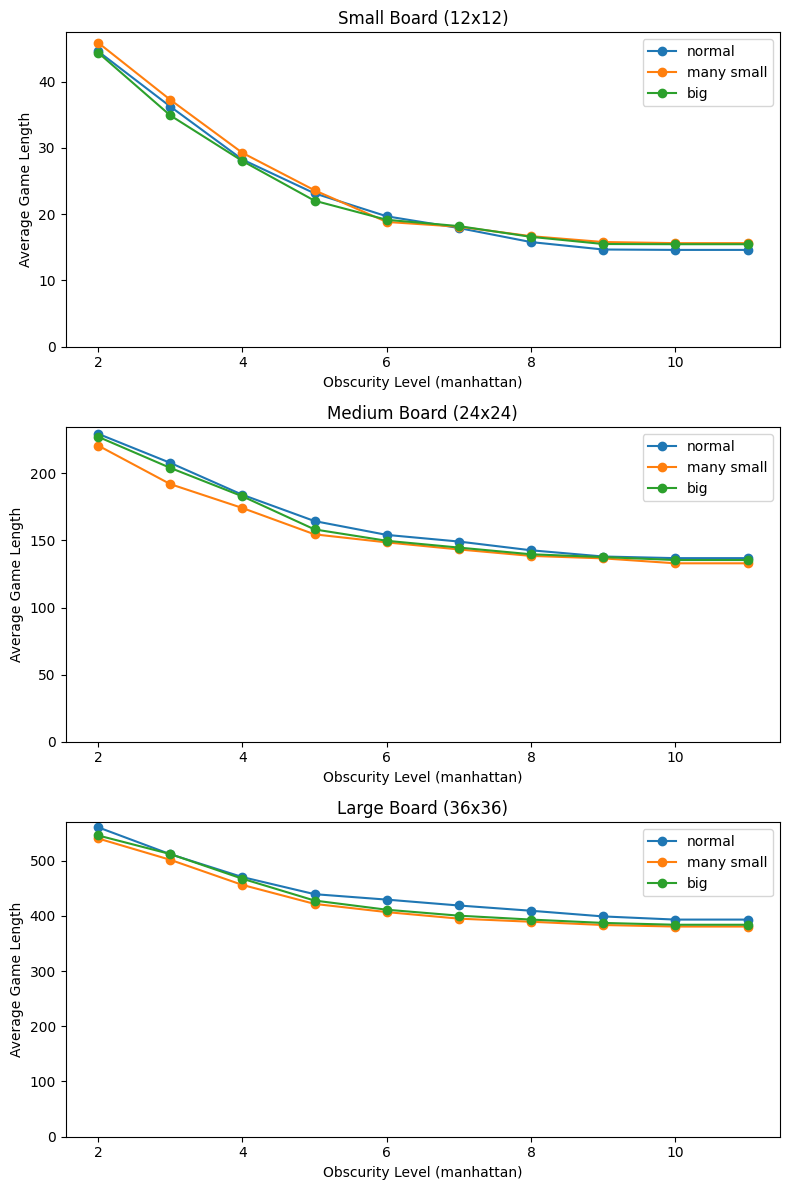

In [8]:
viewing_distances2 = list(range(2, 12, 1))
labels = ["normal", "many small", "big"]

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

board_sets = [
    (axes[0], small_board_results2, "Small Board (12x12)"),
    (axes[1], medium_board_results2, "Medium Board (24x24)"),
    (axes[2], large_board_results2, "Large Board (36x36)"),
]

for ax, board_result, title in board_sets:
    for label, series in zip(labels, board_result):
        ax.plot(viewing_distances2, series, marker="o", label=label)
    ax.set_title(title)
    ax.set_xlabel("Obscurity Level (manhattan)")
    ax.set_ylabel("Average Game Length")
    ax.set_ylim(bottom=0)
    ax.legend()

plt.tight_layout()
plt.show()

### Plotting together

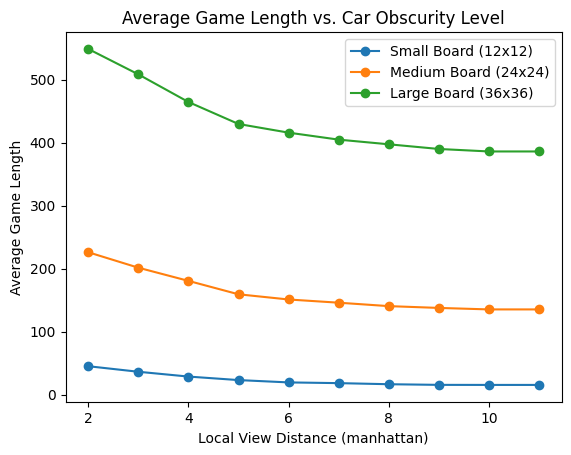

In [26]:
small_avg = [np.mean([small_board_results2[0][i], small_board_results2[1][i], small_board_results2[2][i]]) for i in range(len(viewing_distances2))]
medium_avg = [np.mean([medium_board_results2[0][i], medium_board_results2[1][i], medium_board_results2[2][i]]) for i in range(len(viewing_distances2))]
large_avg = [np.mean([large_board_results2[0][i], large_board_results2[1][i], large_board_results2[2][i]]) for i in range(len(viewing_distances2))]

plt.plot(viewing_distances2, small_avg, marker='o', label='Small Board (12x12)')
plt.plot(viewing_distances2, medium_avg, marker='o', label='Medium Board (24x24)')
plt.plot(viewing_distances2, large_avg, marker='o', label='Large Board (36x36)')
plt.xlabel('Local View Distance (manhattan)')
plt.ylabel('Average Game Length')
plt.title('Average Game Length vs. Car Obscurity Level')
plt.legend()
plt.show()

## Assistance of helpers in finding cars

In [10]:
small_board_results3: tuple[list[float], ...] = ([], [], [])
medium_board_results3: tuple[list[float], ...] = ([], [], [])
large_board_results3: tuple[list[float], ...] = ([], [], [])

obstacle_schemes = [
    DisjointBlobs(max_count=6, max_size=5),   # normal
    DisjointBlobs(max_count=15, max_size=2),  # many small
    DisjointBlobs(max_count=3, max_size=15),  # big
]

base_seed = 42

def avg_runs(game_factory, seed_start: int, runs: int = 200) -> float:
    """Run multiple games with incremental seeds and return average length."""
    return sum(game_factory(seed_start + k) for k in range(runs)) / runs

for i in range(0, 8, 1):
    print(i)

    for idx, obstacle_gen in enumerate(obstacle_schemes):

        # ---- small board ----
        small_board_results3[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=12, w=12, n=11, m=3,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen,
                    num_helpers=i,
                ).play_game(seed),
                base_seed
            )
        )

        # ---- medium board ----
        medium_board_results3[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=24, w=24, n=11, m=3,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen,
                    num_helpers=i,
                ).play_game(seed),
                base_seed
            )
        )

        # ---- large board ----
        large_board_results3[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=36, w=36, n=11, m=3,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen,
                    num_helpers=i,
                ).play_game(seed),
                base_seed
            )
        )

0
1
2
3
4
5
6
7


### Plotting individually

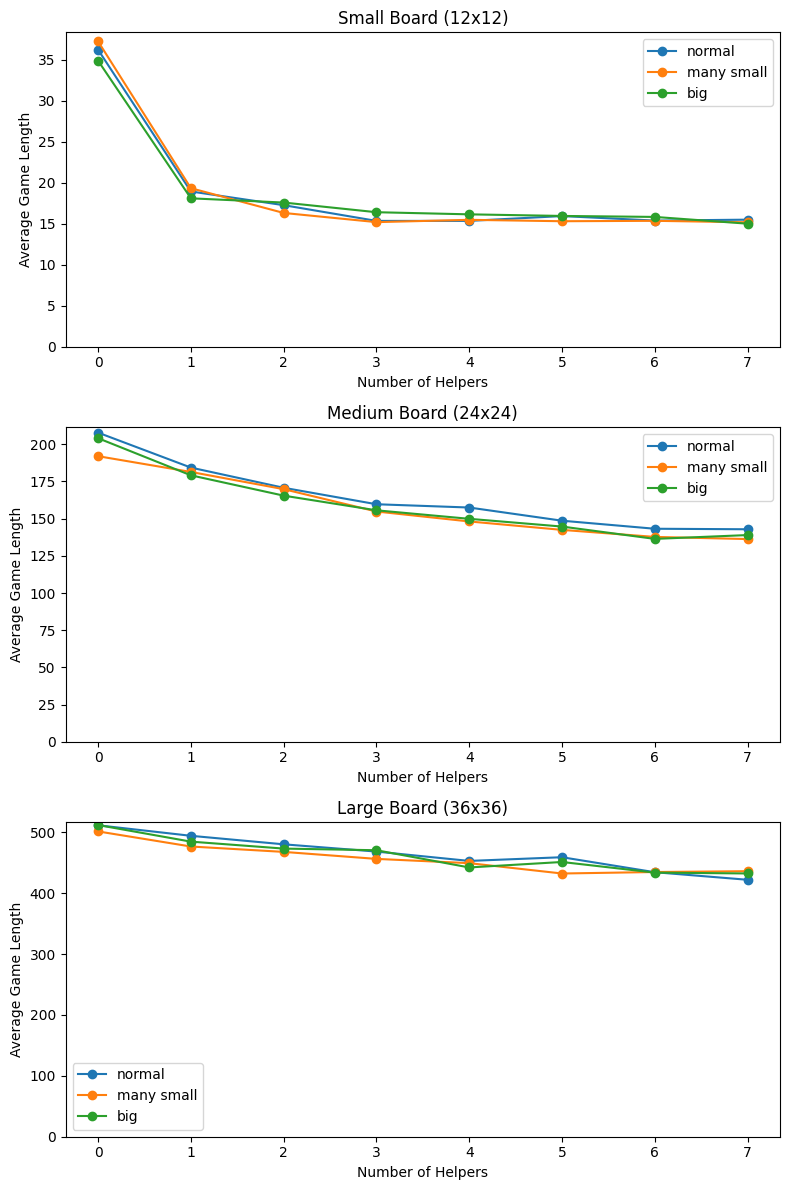

In [12]:
viewing_distances3 = list(range(0, 8, 1))
labels = ["normal", "many small", "big"]

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

board_sets = [
    (axes[0], small_board_results3, "Small Board (12x12)"),
    (axes[1], medium_board_results3, "Medium Board (24x24)"),
    (axes[2], large_board_results3, "Large Board (36x36)"),
]

for ax, board_result, title in board_sets:
    for label, series in zip(labels, board_result):
        ax.plot(viewing_distances3, series, marker="o", label=label)
    ax.set_title(title)
    ax.set_xlabel("Number of Helpers")
    ax.set_ylabel("Average Game Length")
    ax.set_ylim(bottom=0)
    ax.legend()

plt.tight_layout()
plt.show()

### Plotting together

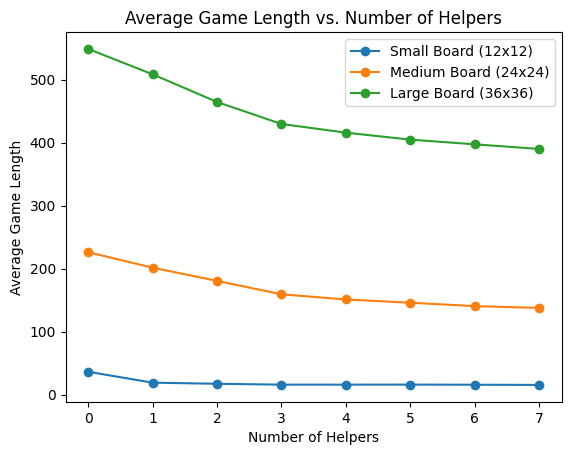

In [31]:
small_avg = [np.mean([small_board_results3[0][i], small_board_results3[1][i], small_board_results3[2][i]]) for i in range(len(viewing_distances3))]
medium_avg = [np.mean([medium_board_results2[0][i], medium_board_results2[1][i], medium_board_results2[2][i]]) for i in range(len(viewing_distances3))]
large_avg = [np.mean([large_board_results2[0][i], large_board_results2[1][i], large_board_results2[2][i]]) for i in range(len(viewing_distances3))]

plt.plot(viewing_distances3, small_avg, marker='o', label='Small Board (12x12)')
plt.plot(viewing_distances3, medium_avg, marker='o', label='Medium Board (24x24)')
plt.plot(viewing_distances3, large_avg, marker='o', label='Large Board (36x36)')
plt.xlabel('Number of Helpers')
plt.ylabel('Average Game Length')
plt.title('Average Game Length vs. Number of Helpers')
plt.legend()
plt.show()